In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image
import requests
import imutils

In [6]:
#enter the url from the IP camera app https://play.google.com/store/apps/details?id=com.pas.webcam&hl=en_US&gl=US
url = "http://10.0.0.78:8080/video"
# While loop to continuously fetching data from the Url
capture = cv2.VideoCapture(url)
while True:
    _, frame = capture.read()
    cv2.imshow('sharesight',frame)
    if cv2.waitKey(1) == ord("x"): #press x to exit the capture window and take a photo image saved as test.png (will be replaced for each capture)
        result,frame = capture.read()
        cv2.imwrite("test.png",frame)
        break
capture.release()
cv2.destroyAllWindows()


In [6]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6) # You can adjust the size of the displayed figure
  plt.imshow(img)
  plt.axis("off")

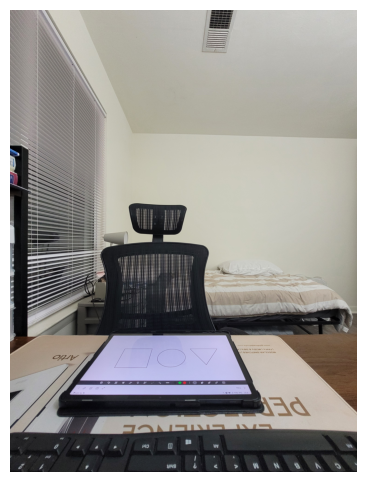

In [10]:
image = load_image("test_04_11/20231104_213128.jpg")
image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
show_image(image)

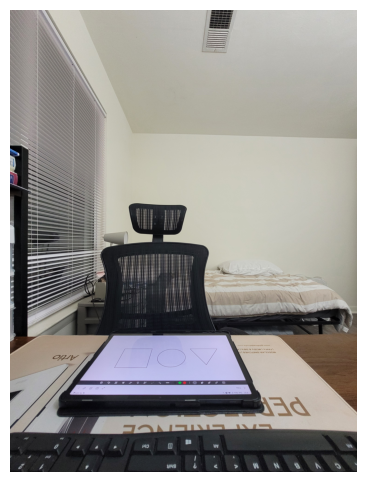

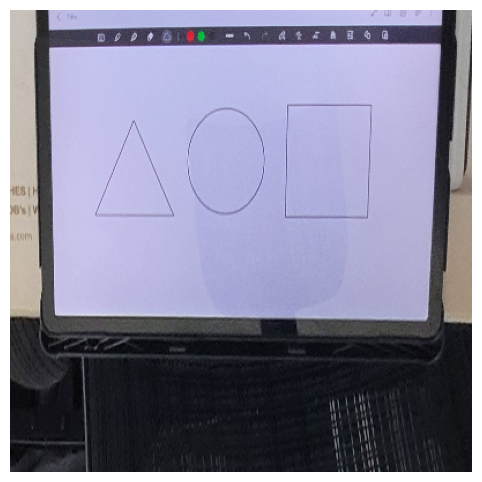

In [11]:
# trapezoid_pts = np.array([[263, 245], [462, 246], [502, 476], [224, 474]], dtype='float32') #for test1

trapezoid_pts = np.array([[885,2690], [1917,2678], [2235,3290], [441,3278]], dtype='float32')

# Define the coordinates of the four corners of the desired rectangle (in the same order)

rectangle_pts = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype='float32')

# Compute the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(trapezoid_pts, rectangle_pts)

# Apply the perspective transformation to the image
transformed_image = cv2.warpPerspective(image, perspective_matrix, (400, 400))  # Adjust the size as needed
transformed_image = cv2.rotate(transformed_image,cv2.ROTATE_180)
show_image(image)
show_image(transformed_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


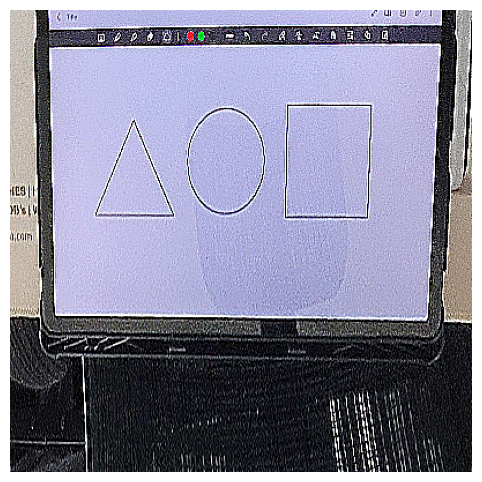

In [12]:
kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
sharpened_image = cv2.filter2D(transformed_image, -1, kernel)
show_image(sharpened_image)
# Brighten the image by increasing the brightness and contrast
# alpha = 1  # Brightness control (1.0 means no change)
# beta = 1  # Contrast control
# brightened_image = cv2.convertScaleAbs(sharpened_image, alpha=alpha, beta=beta)
# show_image(brightened_image)

In [ ]:
#Trying Basic Perspective Transform on Video